<a href="https://colab.research.google.com/github/asifahsaan/T2-Rossman-Sales-Prediction---Time-Series/blob/master/Rossman_Sales_Prediction_Thesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##                                                                                                                 Rossman Sales Prediction

## Approach
1) Data Cleansing                   
2) Exploratory Data Analysis             
3) Feature Selection                        
4) Data Modelling : Model Training is done by parameter tunning through hyperparameter tunning



Import the libraries

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import warnings
import itertools
from pandas import DataFrame


In [2]:
# from google.colab import drive

Upload the test,train and Store file

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
import pandas as pd
store = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/store.csv", low_memory=False)
train = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/train.csv/train.csv", low_memory=False,parse_dates = [2])
test = pd.read_csv("/content/gdrive/MyDrive/Thesis Data/Dataset/test.csv/test.csv", low_memory=False, parse_dates = [3])

In [5]:
# import io
# train = pd.read_csv(io.BytesIO(uploaded['train.csv']),parse_dates=[2], low_memory = False)
# test = pd.read_csv(io.BytesIO(uploaded['test.csv']),parse_dates=[3], low_memory = False)
# store = pd.read_csv(io.BytesIO(uploaded['store.csv']),low_memory=False)

Check the train data

In [6]:
#train
# train.head().append(train.tail())

In [7]:
#test
# test.head().append(test.tail())

In [8]:
#store
# store.head().append(store.tail())

##**Part 1-Exploratory Data Analysis**

check for NAN values in train , test and store data

In [9]:
# display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

In [10]:
# test[pd.isnull(test.Open)]

Store having NAN values for CompetitionOpenSinceMonth

In [11]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


Store having NAN for Promo2SinceWeek

In [12]:
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

The dataset contains the values f Sales which are 0 due to School or State Holiday.              
Plot the train data having sales greater then 0 for Store1   
It can be seen the sales jumps during end of Decemeber each year

In [13]:
# # sales of store1 full timne
# strain = train[train.Sales>0]
# strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

Compare the Sles of Store 1 from 1st June 2016 to 31st July 2014 vs 1st August 2014 - 30th Sept 2014

In [14]:
# strain = train[train.Sales>0]
# strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
# strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

Fill the null values of test datset & Train dataset

In [15]:
# the store should be open in the test,so we fillna with 1
test.fillna(1, inplace=True)

In [16]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

We can see all the null values are replaced and now we can moveahead with our analysis

In [17]:
# display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

In [18]:
train1 = train

In [19]:
train1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [20]:
train2 = pd.merge(train1, store, on='Store')    ## for TimeSeries Arima Model
train2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [21]:
df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

## Part 2-Feature Creation / Feature Selection

Merge the training dataset with the Store dataset
Merge the Test dataset with store dataset

In [22]:
train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2['Sales/Customer'].describe()

df_train_store['Sales/Customer'] = df_train_store['Sales']/df_train_store['Customers']

In [23]:

def features_create(data):
        
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
        
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
      
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [24]:
features_create(df_train_store)
features_create(train2)
features_create(df_test_store)
print('Features creation finished')
train.head()

<ipython-input-23-4f9d082f2aa0>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear
<ipython-input-23-4f9d082f2aa0>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


Features creation finished


<ipython-input-23-4f9d082f2aa0>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


We can see that the Customers,promo, Open and Sales/Customers are highly correlated with sales

<Axes: >

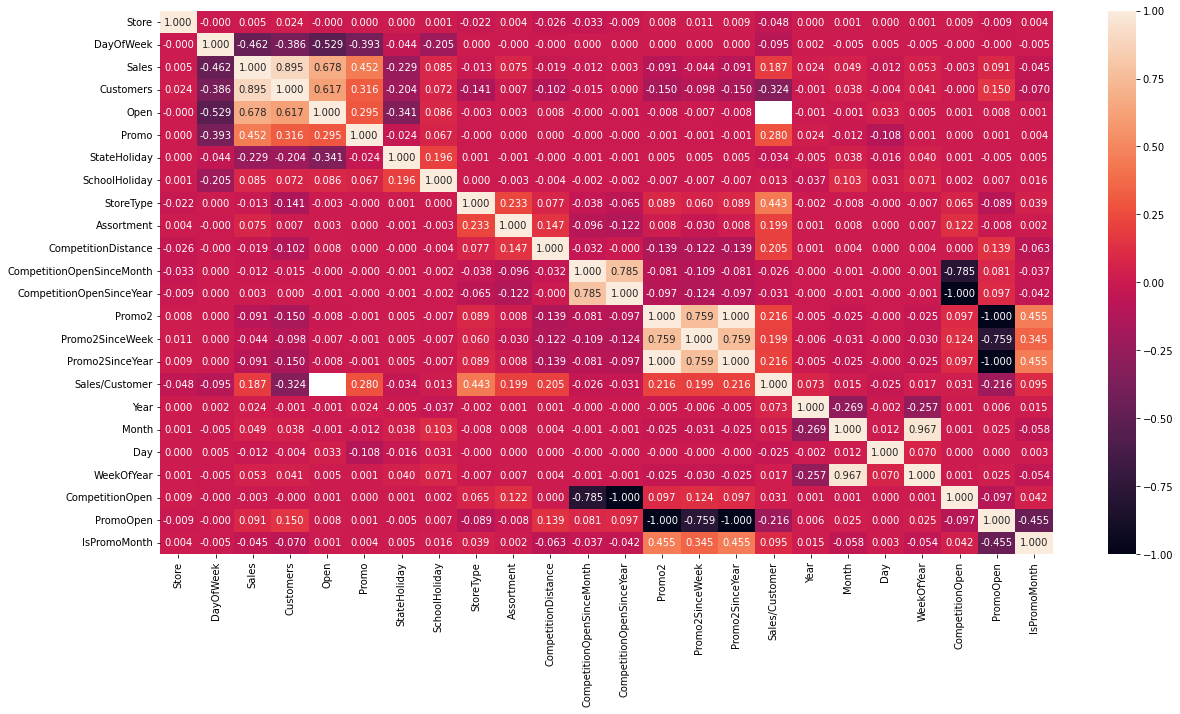

In [25]:
plt.figure(figsize = (20, 10))

sns.heatmap(df_train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

#**Part 3-Model Training  : **

##2)XGBoost

Now lets split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)

In [26]:
train_xg = df_train_store.sort_values(['Date'],ascending = False)
ho_test = df_train_store[:6*7*1115]
ho_train = df_train_store[6*7*1115:]

We will consider only data of Sales>0 and Open is 1

In [27]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

Create the training and testing dataset 

We will drop the features of not help

In [28]:
ho_train.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)
xtest =df_test_store.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

<ipython-input-28-875faa5a38bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ho_train.drop(['Date','Open','PromoInterval','monthStr'],axis=1,inplace =True)


Create Features and Label data for Test and Train

In [29]:
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

Create a function to calculate Rmse and RMPSe

In [30]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

Create a evaluation list having training and testing set which will cause the XGBOOst evaluate both the sets during running .


In [31]:
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

Hyperparameter tunning is done with the important parameters.

XGBoost is run for 6000 itertion and habe an early stopping round of 100.

Validation is done of the tarined model and RMPSE is displayed as sonn as the below function ends.

In [33]:
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 6000           #countinue for 6000 itertions


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

# Save your final model
# gbm.save_model('my_model.h5')
# from google.colab import files
# files.download('my_model.h5')


print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[12:56:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[1002]	train-rmse:0.00497	train-rmspe:0.00497	eval-rmse:0.02250	eval-rmspe:0.02201
[1003]	train-rmse:0.00497	train-rmspe:0.00497	eval-rmse:0.02250	eval-rmspe:0.02201
[1004]	train-rmse:0.00497	train-rmspe:0.00497	eval-rmse:0.02250	eval-rmspe:0.02201
[1005]	train-rmse:0.00497	train-rmspe:0.00497	eval-rmse:0.02250	eval-rmspe:0.02201
[1006]	train-rmse:0.00497	train-rmspe:0.00496	eval-rmse:0.02249	eval-rmspe:0.02200
[1007]	train-rmse:0.00496	train-rmspe:0.00496	eval-rmse:0.02249	eval-rmspe:0.02200
[1008]	train-rmse:0.00496	train-rmspe:0.00496	eval-rmse:0.02248	eval-rmspe:0.02199
[1009]	train-rmse:0.00496	train-rmspe:0.00496	eval-rmse:0.02248	eval-rmspe:0.02199
[1010]	train-rmse:0.00496	train-rmspe:0.00496	eval-rmse:0.02248	eval-rmspe:0.02199
[1011]	train-rmse:0.00495	train-rmspe:0.00495	eval-rmse:0.02248	eval-rmspe:0.02199
[1012]	train-rmse:0.00495	train-rmspe:0.00495	eval-rmse:0.02248	eval-rmspe:0.02199
[1013]	train-rmse:0.00495	train-rmsp

In [39]:
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.019615


In [40]:
df_predict = pd.DataFrame(yhat)
df_predict.head()

,0
0,8.567917
1,8.522410
2,8.475389
3,8.518140
4,8.709117


In [48]:
df_predict.to_csv("predicted.csv")

Create a new dataframe having actual , predicted values , ratio , error and weight 

In [41]:
# analysis by hold-out set
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,555,1,0,1,3,1,1270.0,9.0,...,31,31,82.0,24187.75,0,8.568646,8.567917,0.999915,0.000085,1.000085
1,1,3,546,1,0,1,3,1,1270.0,9.0,...,30,31,82.0,24187.75,0,8.521384,8.522410,1.000120,0.000120,0.999880
2,1,2,523,1,0,1,3,1,1270.0,9.0,...,29,31,82.0,24187.75,0,8.472823,8.475389,1.000303,0.000303,0.999697
3,1,1,560,1,0,1,3,1,1270.0,9.0,...,28,31,82.0,24187.75,0,8.519590,8.518140,0.999830,0.000170,1.000170
4,1,0,612,1,0,1,3,1,1270.0,9.0,...,27,31,82.0,24187.75,0,8.716536,8.709117,0.999149,0.000851,1.000852


Check the worst 10 samples

In [42]:
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
37972,42,5,1013,0,0,0,1,3,290.0,0.0,...,3,18,24173.0,30.50,0,9.071538,8.905919,0.981743,0.018257,1.018596
27666,30,0,93,0,0,0,1,1,40.0,2.0,...,11,7,0.0,0.00,0,6.418365,6.533497,1.017938,0.017938,0.982378
38392,42,5,822,0,0,0,1,3,290.0,0.0,...,9,10,24159.0,16.50,0,8.864747,8.706986,0.982204,0.017796,1.018119
38028,42,5,1007,0,0,0,1,3,290.0,0.0,...,8,10,24171.0,28.50,0,9.066239,8.905071,0.982223,0.017777,1.018098
37958,42,5,918,0,0,0,1,3,290.0,0.0,...,17,20,24173.0,31.00,0,8.974998,8.816820,0.982376,0.017624,1.017940
37979,42,5,895,0,0,0,1,3,290.0,0.0,...,26,17,24172.0,30.25,1,8.935114,8.778074,0.982424,0.017576,1.017890
37867,42,5,955,0,0,0,1,3,290.0,0.0,...,16,33,24176.0,34.25,0,9.002332,8.844505,0.982468,0.017532,1.017845
37881,42,5,977,0,0,0,1,3,290.0,0.0,...,2,31,24176.0,33.75,0,9.033126,8.875232,0.982521,0.017479,1.017790
37832,42,5,855,0,0,0,1,3,290.0,0.0,...,20,38,24177.0,35.50,0,8.891787,8.737155,0.982610,0.017390,1.017698
37783,42,5,1164,0,0,0,1,3,290.0,0.0,...,8,45,24179.0,37.25,0,9.210940,9.050977,0.982633,0.017367,1.017674


XGBoost model uses boosting technique to boost the weak learners and updates the weights to improve the model predictions.

Lets do some correction of the weights to improve our RMPSE score.

It can be seen that weight 0.995 gives 0.112 RMSe

weight correction
RMSPE for 0.990:0.086513
RMSPE for 0.991:0.078714
RMSPE for 0.992:0.070898
RMSPE for 0.993:0.063086
RMSPE for 0.994:0.055310
RMSPE for 0.995:0.047625
RMSPE for 0.996:0.040129
RMSPE for 0.997:0.033005
RMSPE for 0.998:0.026624
RMSPE for 0.999:0.021741
RMSPE for 1.000:0.019615
RMSPE for 1.001:0.021189
RMSPE for 1.002:0.025873
RMSPE for 1.003:0.032407
RMSPE for 1.004:0.039944
RMSPE for 1.005:0.048059
RMSPE for 1.006:0.056543
RMSPE for 1.007:0.065285
RMSPE for 1.008:0.074226
RMSPE for 1.009:0.083329
Best weight for Score:1.0    0.019615
dtype: float64


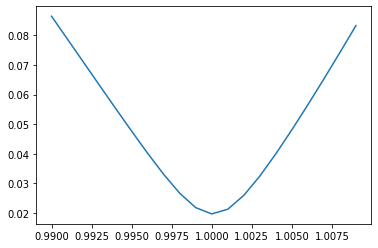

In [43]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [44]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']

In [49]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [50]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.011720


In [53]:
df_test_store

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,3,2015-09-17,1.0,1,0,0,3,1,1270.0,...,0.0,,2015,9,17,38,84.0,24189.50,Sept,0
1,1,2,2015-09-16,1.0,1,0,0,3,1,1270.0,...,0.0,,2015,9,16,38,84.0,24189.50,Sept,0
2,1,1,2015-09-15,1.0,1,0,0,3,1,1270.0,...,0.0,,2015,9,15,38,84.0,24189.50,Sept,0
3,1,0,2015-09-14,1.0,1,0,0,3,1,1270.0,...,0.0,,2015,9,14,38,84.0,24189.50,Sept,0
4,1,6,2015-09-13,0.0,0,0,0,3,1,1270.0,...,0.0,,2015,9,13,37,84.0,24189.25,Sept,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1115,2,2015-08-05,1.0,1,0,1,4,3,5350.0,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,5,32,24188.0,38.50,Aug,0
41084,1115,1,2015-08-04,1.0,1,0,1,4,3,5350.0,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,4,32,24188.0,38.50,Aug,0
41085,1115,0,2015-08-03,1.0,1,0,1,4,3,5350.0,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,3,32,24188.0,38.50,Aug,0
41086,1115,6,2015-08-02,0.0,0,0,1,4,3,5350.0,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,2,31,24188.0,38.25,Aug,0


In [57]:
df_test_store.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'monthStr',
       'IsPromoMonth'],
      dtype='object')

In [54]:
df_test_store.to_csv("Predicted_store_sales.csv")